In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer #Using porterstemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer           

Using TensorFlow backend.
/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shikharghimire/anacond

In [2]:
#Importing the data
reviews = pd.read_csv('IMDB.csv')

In [3]:
#Let's visualise the rate of sentiments(positive and negative)
sentiment_counts = reviews['sentiment'].value_counts()

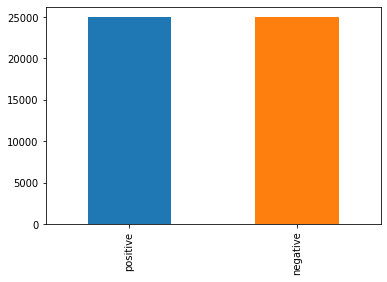

In [4]:
sentiment_counts.plot(kind='bar',color=['C0','C1'])

In [5]:
# lem = WordNetLemmatizer()
# def word_cleanup(text):
#     reviews = re.sub('\[.*?\]', '', text) # remove square brackets
#     reviews = re.sub(r'[^\w\s]','',reviews) # remove punctuation
#     reviews = re.sub('\w*\d\w*', '', reviews) # remove words containing numbers
#     reviews = re.sub(r'http\S+', '', reviews) #Removes links
#     reviews = re.sub('\n', '', reviews)
#     reviews = re.sub('<.*?>','',reviews)
#     reviews = nltk.word_tokenize(reviews) #Splitting all the sentences into individual words
#     reviews = [word.lower() for word in reviews] #lowering all the alphabets
#     reviews = [lem.lemmatize(word) for word in reviews if not word in set(stopwords.words('english'))]
#     reviews = ' '.join(reviews)
#     return reviews

In [6]:
# reviews['review'] = reviews['review'].apply(word_cleanup)

In [7]:
# reviews.to_csv('cleanedreviews.csv')

In [8]:
data = pd.read_csv('cleanedreviews.csv')

In [9]:
#Removing the html br tag
data['review'] = data['review'].str.replace('br','')

In [10]:
#Let's use wordclouds to check the most number of words that occured
def word_cloud(string):
    wordcloud = WordCloud(
    width = 500,
    height = 500,
    background_color = 'white').generate(str(string))
    fig = plt.figure(
        figsize = (5, 10),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [11]:
positive_reviews = data[data['sentiment']=='positive']
negative_reviews = data[data['sentiment']=='negative']

In [12]:
positive_reviews_only = positive_reviews['review']
negative_reviews_only = negative_reviews['review']

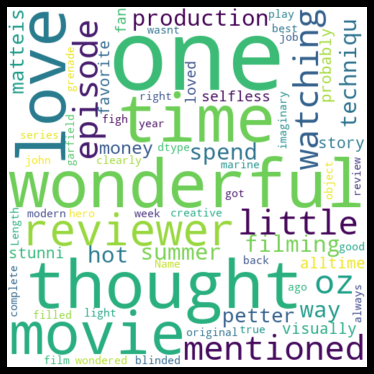

In [13]:
word_cloud(positive_reviews_only)

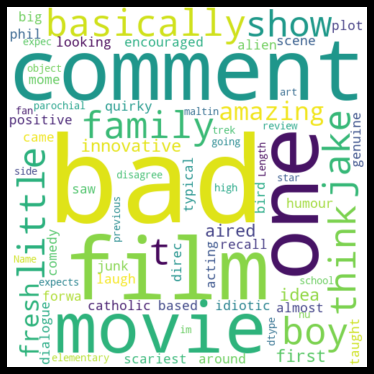

In [14]:
word_cloud(negative_reviews_only)

In [15]:
#Let's check the most occured word in both positive and negative reviews
top_ten_positive_words = Counter(''.join(positive_reviews_only).split()).most_common(10)
top_ten_negative_words = Counter(''.join(negative_reviews_only).split()).most_common(10)

In [16]:
top_ten_positive_words

[('film', 47283),
 ('movie', 41919),
 ('one', 26561),
 ('like', 17367),
 ('time', 15188),
 ('good', 14361),
 ('story', 13682),
 ('character', 13674),
 ('great', 12546),
 ('see', 12288)]

In [17]:
top_ten_negative_words

[('movie', 54443),
 ('film', 41462),
 ('one', 25361),
 ('like', 22074),
 ('even', 15014),
 ('good', 14172),
 ('bad', 14078),
 ('time', 14036),
 ('character', 14000),
 ('would', 13543)]

In [18]:
#Zipping the files to plot the graph
poslabels,posnumbers = zip(*top_ten_positive_words)
neglabels,negnumbers = zip(*top_ten_negative_words)

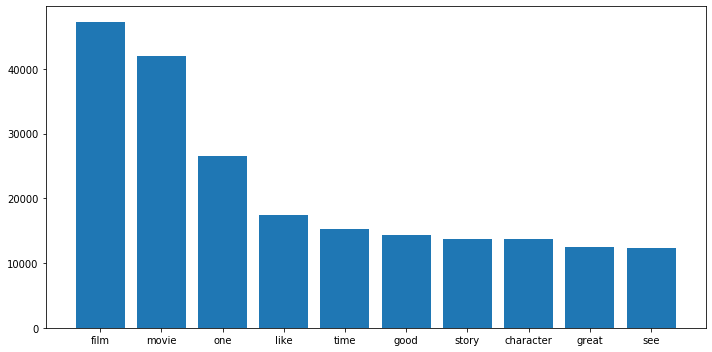

In [19]:
#Plotting the most occured files in the graphs
#Positive reviews
plt.figure(figsize=(10,5))
x_axis = np.arange(len(poslabels)) 
plt.bar(x_axis, posnumbers,width=0.8, align='center')
plt.xticks(x_axis, poslabels)
plt.tight_layout()
plt.show()

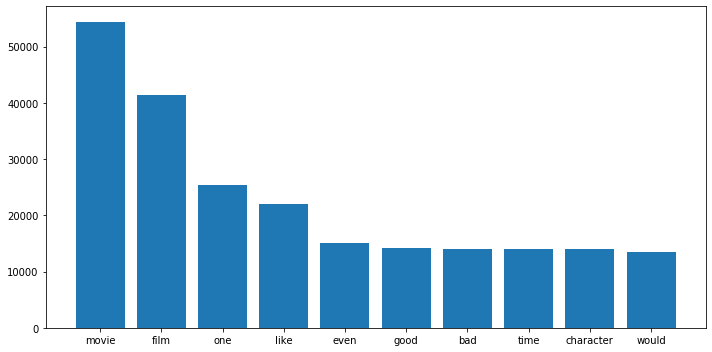

In [20]:
#Negative reviews
plt.figure(figsize=(10,5))
x_axis = np.arange(len(neglabels)) 
plt.bar(x_axis, negnumbers,width=0.8, align='center')
plt.xticks(x_axis, neglabels)
plt.tight_layout()
plt.show()

In [21]:
#Testing various grams for the classification
data.head()

,Unnamed: 0,review,sentiment
0,0,one reviewer mentioned watching oz episode you...,positive
1,1,wonderful little production filming techniqu...,positive
2,2,thought wonderful way spend time hot summer we...,positive
3,3,basically there family little boy jake think t...,negative
4,4,petter matteis love time money visually stunni...,positive


In [22]:
data = data.dropna()

In [23]:
words = ' '.join(data['review'])

In [24]:
words = word_tokenize(words)

## Using different number of grams

### Let's use bigrams

In [25]:
bi_gram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]

In [26]:
tri_gram = (pd.Series(nltk.ngrams(words,3)).value_counts())[:20]

Text(0.5, 0, 'No of Occurances')

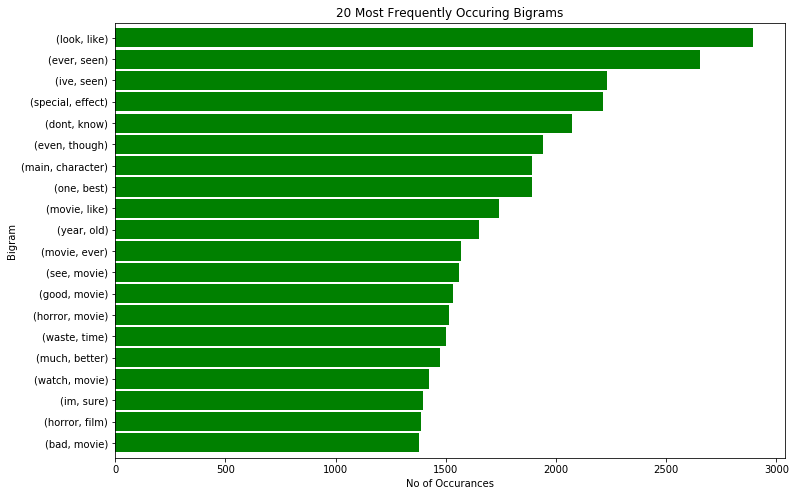

In [27]:
#Visualising the n grams using bar plot
#bigrams
bi_gram.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('No of Occurances')

Text(0.5, 0, 'No of Occurances')

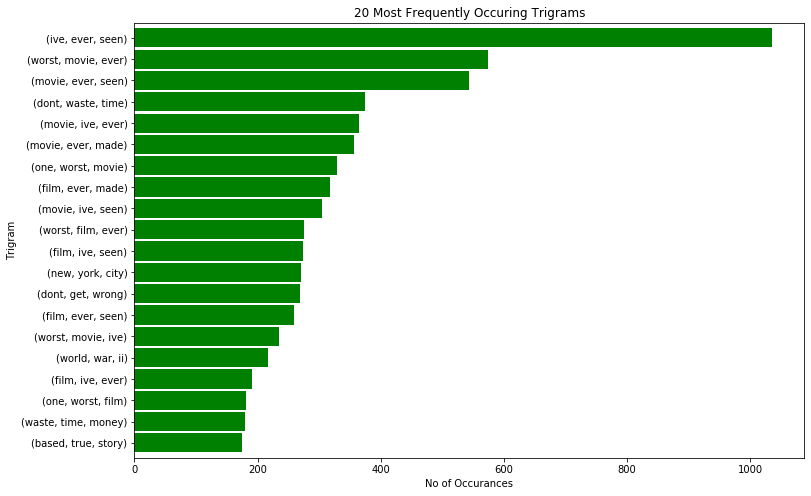

In [29]:
#Visualising the n grams using bar plot
#trigrams
tri_gram.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('No of Occurances')

### Using convolution neural network for nlp


In [30]:
data = data[['review','sentiment']]

In [31]:
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode you...,positive
1,wonderful little production filming techniqu...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


In [33]:
X = data['review'].values
Y = data['sentiment'].values

In [38]:
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

In [39]:
#Splitting the data into training and testing set
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

In [83]:
all_training_words = [i.split() for i in train_data['review']]
all_training_wordings = []
for i in range(len(all_training_words)):
    for j in range(len(all_training_words[i])):
        all_training_wordings.append(all_training_words[i][j])
training_vocab = sorted(list(set(all_training_wordings)))

In [84]:
all_testing_words = [i.split() for i in test_data['review']]
all_testing_wordings = []
for i in range(len(all_testing_words)):
    for j in range(len(all_testing_words[i])):
        all_testing_wordings.append(all_testing_words[i][j])
testing_vocab = sorted(list(set(all_testing_wordings)))

In [86]:
tokenizer_train = Tokenizer(num_words = len(training_vocab))
tokenizer_test = Tokenizer(num_words = len(testing_vocab))

In [89]:
tokenizer_train.fit_on_texts(X_train)
tokenizer_test.fit_on_texts(X_test)

In [92]:
train_vocabulary_size = len(tokenizer_train.word_index)+1
test_vocabulary_size = len(tokenizer_test.word_index)+1

In [ ]:
X_train = pad_sequence(X_train, padding = 'post')
X_test = pad_sequence(X_test.padding = 'post')